## Barrier option by Monte Carlo
As before, we continue to work within the Black/Scholes model, so the price of the underlying stock follows Geometric Brownian motion, with the dynamics under the risk-neutral measure given by
$$S(T)=S(t)\exp\left\{\left(r−\frac12\sigma^2\right)(T−t)+\sigma(W(T)−W(t))\right\}$$
Consider a down-and-out call option, i.e. an option which at expiry $T$ with strike price $K$ has the same payoff as a standard European call option, unless at some time between time 0 and $T$ the price of the underlying stock has fallen below a given barrier $H$. The time 0 value of this option can be expressed as the expectation under the risk-neutral measure of  
$$C=E\left[e^{−rT}\max(0,S(T)−K){\mathbb{I}}\{S(t)>H\ \forall\ 0\leq t\leq T\}\right]$$
where the indicator function
$${\mathbb{I}}\{S(t)>H\ \forall\ 0\leq t\leq T\}$$
equals one unless the underlying stock falls below the barrier $H$.

Thus we can write a Python function which calculates the Monte Carlo estimate `MC` for the Black/Scholes price of the option and the standard deviation `MCstd` of the simulation mean, where the function takes eight arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$, $H$, the number of sampling iterations of the Monte Carlo algorithm $n$, and the number of time steps $m$ on each simulated price path. Note that this is a necessary approximation, since we can only simulate stock price paths with discrete time steps. The change in the stock price on each time step is simulated by drawing from the distribution given by the transition probability density function:

In [1]:
import numpy as np

def BlackScholesBarrierMC(S,K,sgm,r,T,H,n,m):
    dt = T/m
    acc = 0.0
    acc2 = 0.0
    for i in range(0,n):
        S_t = S
        alive = True
        for j in range(0,m):
            S_t = S_t*np.exp((r-0.5*sgm**2)*dt+sgm*np.sqrt(dt)*np.random.standard_normal())
            if S_t <= H:
                alive = False
                break
        if alive:
            payoff=S_t-K 
            payoff=payoff*(payoff>0)
            acc = acc + payoff
            acc2 = acc2 + payoff*payoff
    MC=np.exp(-r*T)*acc/n
    MCstd=np.exp(-r*T)*np.sqrt(acc2/n-acc*acc/n**2)/np.sqrt(n)
    return MC, MCstd

To run this code with user inputs:

In [2]:
stock = float(input('Enter the underlying stock price: '))
strike = float(input('Enter the strike price: '))
sigma = float(input('Enter the volatility: '))
interest = float(input('Enter continuously compounded interest rate: '))
maturity = float(input('Enter the time to maturity: '))
barrier = float(input('Enter the barrier: '))
n = int(input('Enter the number of simulations: '))
m = int(input('Enter the number of time steps: '))
MC, MCstd = BlackScholesBarrierMC(stock,strike,sigma,interest,maturity,barrier,n,m)
print('The MC estimate for the option price is: ')
print(MC)
print('The 2 standard deviation confidence interval for the option price is: ')
print(MC-2*MCstd,MC+2*MCstd)

Enter the underlying stock price: 100
Enter the strike price: 100
Enter the volatility: 0.3
Enter continuously compounded interest rate: 0.05
Enter the time to maturity: 2.5
Enter the barrier: 90
Enter the number of simulations: 1000
Enter the number of time steps: 100
The MC estimate for the option price is: 
13.140487475684035
The 2 standard deviation confidence interval for the option price is: 
10.85737446585313 15.423600485514939


In [52]:
import numpy as np
def BlackScholesAsianMC(S,K,sgm,r,T,n,m):
    dt = T/m
    acc = 0.0
    acc2 = 0.0
    for i in range(0,n):
        S_t = S
        stvec = []
        for j in range(0,m):
            S_t = S_t*np.exp((r-0.5*sgm**2)*dt+sgm*np.sqrt(dt)*np.random.standard_normal())
            stvec.append(S_t)
        #print (stvec)
        #print (sum(stvec)/m)
        payoff = (sum(stvec)/m) - K
        payoff=payoff*(payoff>0)
        acc =  acc+payoff
        acc2 = acc2 + payoff*payoff
    MC = np.exp(-r*T)*acc/n
    MCstd = np.exp(-r*T)*np.sqrt(acc2/n-acc*acc/n**2)/np.sqrt(n)
    return MC, MCstd
        
#         if alive:
#             payoff=S_t-K 
#             payoff=payoff*(payoff>0)
#             acc = acc + payoff
#             acc2 = acc2 + payoff*payoff
#     MC=np.exp(-r*T)*acc/n
#     MCstd=np.exp(-r*T)*np.sqrt(acc2/n-acc*acc/n**2)/np.sqrt(n)
#    return MC, MCstd

In [54]:
BlackScholesAsianMC(100,100,0.3,0.02,2,10000,5)

(12.005122069801892, 0.20423435812613927)

In [50]:
import numpy as np
from scipy.stats import norm
def GeoAvgOption(S0,K, m, sig, r, T):
    dt = T/m
    tau_til = T - dt*((m-1)/2)
    tau = T - dt*((m*(m-1)*(4*m+1))/(6*m*m))
    d = ((np.log(S0/K)+ (r - 0.5*sig*sig)*tau_til))/(sig*np.sqrt(tau))
    A0 = np.exp(-r*(T-tau_til) - sig*sig*((tau_til-tau)/2))
    Cgeo = S0*A0*norm.cdf(d+sig*np.sqrt(tau)) - K*np.exp(-r*T)*norm.cdf(d)
    return Cgeo

GeoAvgOption(100,100, 4, 0.2, 0.02, 2)

8.425282694361364

In [51]:
def AvgMCCV(S,K,m,sgm,r,T,n):
    dt=T/m
    acc = 0
    acc2 = 0
    for i in range(0,n):
        lnS_t = np.log(S)
        avg = 0
        geo = 0
        for j in range (0,m):
            lnS_t += ((r-0.5*sgm*sgm)*dt+sgm*np.sqrt(dt)*np.random.standard_normal())
            geo += lnS_t
            S_t = np.exp(lnS_t)
            avg += S_t
        #payoff arithmatic    
        payoff=avg/m-K
        payoff = payoff*(payoff>0)
        #payoff geometric
        payoff2= np.exp(geo/m)-K
        payoff2=payoff2*(payoff>0)
        #payoff diff
        payoff -= payoff2
        acc = acc + payoff
        acc2 = acc2 + payoff * payoff
    MC = np.exp(-r*T)*acc/n + GeoAvgOption(S,K,m,sgm,r,T)
    MCstd = np.exp(-r*T)*np.sqrt(acc2/n-acc/n**2)/np.sqrt(n)
    return MC, MCstd
        

In [55]:
AvgMCCV(100, 100, 5,0.3,0.02,2,1000)

(12.154503280456098, 0.0627432743148017)

In [56]:
def BlackScholes(S,K,sgm,r,T,callput):
    d1= (np.log(S/K)+(r+0.5*sgm*sgm)*T)/(sgm*np.sqrt(T))
    d2 = d1- sgm*np.sqrt(T)
    return callput*(S*norm.cdf(callput*d1)-K*np.exp(-r*T)*norm.cdf(callput*d2))

def LognormalMixtureOption(A0, K,eta,lam,r,T,alpha,callput):
    result = 0
    calA = A0*(1-alpha)
    calK = K - A0*alpha*np.exp(r*T)
    for i in range(0,len(eta)):
        result += lam[i]*BlackScholes(calA, calK, eta[i], r, T, callput)
    return result

In [57]:
import pandas as pd
GOOGopt = pd.read_excel('GOOG.xlsx', index_col = False, parse_dates = [3,6])
GOOGopt.head()

,symbol,exchange,company_name,date,stock_price_close,option_symbol,option_expiration,strike,call_put,style,ask,bid,settlement,volume,open_interest,stock_price_for_iv
0,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOUDQ,2006-04-22,185,C,A,205.399994,204.600006,0,0,394,389.700012
1,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOUPQ,2006-04-22,185,P,A,0.050000,0.000000,0,0,383,389.700012
2,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOUDR,2006-04-22,190,C,A,200.399994,199.600006,0,0,316,389.700012
3,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOUPR,2006-04-22,190,P,A,0.050000,0.000000,0,0,290,389.700012
4,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOUDS,2006-04-22,195,C,A,195.500000,194.600006,0,0,289,389.700012


In [58]:
df = GOOGopt.loc[GOOGopt['call_put']=='C']
df = df.loc[(df['option_expiration']== '2006-06-17')]
df = df.loc[df['volume'] >100]
df

,symbol,exchange,company_name,date,stock_price_close,option_symbol,option_expiration,strike,call_put,style,ask,bid,settlement,volume,open_interest,stock_price_for_iv
258,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GGDFN,2006-06-17,370,C,A,39.900002,39.299999,0,444,2144,389.700012
262,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFR,2006-06-17,390,C,A,28.400000,28.000000,0,131,2801,389.700012
264,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFT,2006-06-17,400,C,A,23.600000,23.200001,0,300,8908,389.700012
266,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFB,2006-06-17,410,C,A,19.400000,19.100000,0,526,2846,389.700012
268,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFD,2006-06-17,420,C,A,15.900000,15.500000,0,193,2519,389.700012
270,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFF,2006-06-17,430,C,A,12.900000,12.500000,0,211,2754,389.700012
272,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFH,2006-06-17,440,C,A,10.400000,10.000000,0,169,2416,389.700012
274,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFJ,2006-06-17,450,C,A,8.200000,7.900000,0,174,4191,389.700012
278,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFG,2006-06-17,470,C,A,5.200000,5.000000,0,108,1838,389.700012
296,GOOG,NASDAQ,Google Inc,2006-04-03,195.039154,GOPFZ,2006-06-17,560,C,A,0.750000,0.650000,0,381,1846,389.700012


In [64]:
import scipy.optimize as opt 
import matplotlib.pyplot as plt
%matplotlib inline 

def BlackScholesSGM(sgm, S, K, r, T, callput, price):
    return price - BlackScholes(S,K, sgm,r,T, callput)

def BlackScholesImpVol(S,K,r,T,callput, price):
    sol = opt.root_scalar(BlackScholesSGM, bracket=[0.0001,1], args = (S,K,r,T,callput,price))
    return sol.root

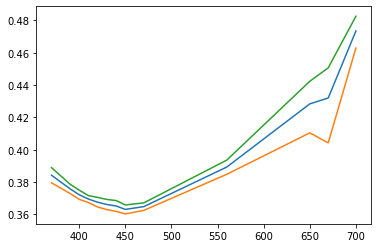

In [74]:
S0 = df['stock_price_for_iv'][df.index[0]]

tau = (df['option_expiration'][df.index[0]]-df['date'][df.index[0]]).days/365

r = np.log(1+0.05/4)*4

smile =pd.DataFrame(columns=['Strike', 'Implied vol','Implied vol bid', 'Implied vol ask'])
smile = smile.set_index('Strike')

for x in df.index:
    K = df['strike'][x]
    price = (df['ask'][x] +df['bid'][x])/2
    smile.loc[K] = (BlackScholesImpVol(S0, K, r,tau,1,price), BlackScholesImpVol(S0, K, r,tau,1,df['bid'][x]), BlackScholesImpVol(S0, K, r,tau,1,df['ask'][x]))
    
plt.plot(smile['Implied vol'])
plt.plot(smile['Implied vol bid'])
plt.plot(smile['Implied vol ask'])

In [79]:
def objective_function(par, args):
    S,r,ttm,df, dim = args
    eta = par[:dim]
    lam = list(par[dim:dim*2-1])
    lam.append(1-sum(lam))
    alpha = par[dim*2-1]
    err= 0
    for x in df.index:
        strike = df['strike'][x]
        price = LognormalMixtureOption(S, strike, eta,lam, r, ttm, alpha, 1)
        if (price>df['ask'][x]):
            err += ((price-df['ask'][x])/df['ask'][x])**2
        if (price<df['bid'][x]):
            err += ((price-df['bid'][x])/df['bid'][x])**2
    return err

In [80]:
par = 0.3,0.20, .5, 0.1
result = opt.minimize(objective_function,par, args = [S0,r,tau,df,2],method = 'Nelder-Mead', tol =0.01)

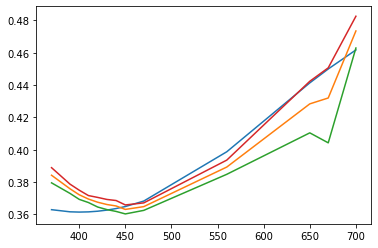

In [84]:
dim =2
eta = result.x[:dim]
lam =list(result.x[dim:dim*2-1])
lam.append(1-sum(lam))
alpha = result.x[-1]

strikelist = smile.index
impvollist = []
for strike in strikelist:
    price = LognormalMixtureOption(S0, strike, eta, lam, r, tau, alpha, 1)
    impvol = BlackScholesImpVol(S0,strike,r,tau,1,price)
    impvollist.append(impvol)
plt.plot(strikelist, impvollist)
plt.plot(smile['Implied vol'])
plt.plot(smile['Implied vol bid'])
plt.plot(smile['Implied vol ask'])
plt.show()